# Xarray Tutorial

### Why?

Xarray introduces labels in the form of dimensions, coordinates and attributes on top of raw NumPy-like multidimensional arrays, which allows for a more intuitive, more concise, and less error-prone developer experience.

### What labels enable
Multi-dimensional (a.k.a. N-dimensional, ND) arrays (sometimes called “tensors”) are an essential part of computational science. They are encountered in a wide range of fields, including physics, astronomy, geoscience, bioinformatics, engineering, finance, and deep learning. In Python, NumPy provides the fundamental data structure and API for working with raw ND arrays. However, real-world datasets are usually more than just raw numbers; they have labels which encode information about how the array values map to locations in space, time, etc.

Xarray doesn’t just keep track of labels on arrays – it uses them to provide a powerful and concise interface. For example:

- Apply operations over dimensions by name: x.sum('time').<br>
- Select values by label (or logical location) instead of integer location: x.loc['2014-01-01'] or x.sel(time='2014-01-01').<br>
- Mathematical operations (e.g., x - y) vectorize across multiple dimensions (array broadcasting) based on dimension names, not shape.<br>
- Easily use the split-apply-combine paradigm with groupby: x.groupby('time.dayofyear').mean().<br>
- Database-like alignment based on coordinate labels that smoothly handles missing values: x, y = xr.align(x, y, join='outer').<br>
- §Keep track of arbitrary metadata in the form of a Python dictionary: x.attrs.<br>

The N-dimensional nature of xarray’s data structures makes it suitable for dealing with multi-dimensional scientific data, and its use of dimension names instead of axis labels (dim='time' instead of axis=0) makes such arrays much more manageable than the raw numpy ndarray: with xarray, you don’t need to keep track of the order of an array’s dimensions or insert dummy dimensions of size 1 to align arrays (e.g., using np.newaxis).

The immediate payoff of using xarray is that you’ll write less code. The long-term payoff is that you’ll understand what you were thinking when you come back to look at it weeks or months later.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import xarray as xr

In [2]:
np.random.seed(123)

xr.set_options(display_style="html")

times = pd.date_range("2000-01-01", "2001-12-31", name="time")
annual_cycle = np.sin(2 * np.pi * (times.dayofyear.values / 365.25 - 0.28))

base = 10 + 15 * annual_cycle.reshape(-1, 1)
tmin_values = base + 3 * np.random.randn(annual_cycle.size, 3)
tmax_values = base + 10 + 3 * np.random.randn(annual_cycle.size, 3)

ds = xr.Dataset(
    {
        "tmin": (("time", "location"), tmin_values),
        "tmax": (("time", "location"), tmax_values),
    },
    {"time": times, "location": ["IA", "IN", "IL"]},
)

ds

<xarray.Dataset>
Dimensions:   (location: 3, time: 731)
Coordinates:
  * time      (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2001-12-31
  * location  (location) <U2 'IA' 'IN' 'IL'
Data variables:
    tmin      (time, location) float64 -8.037 -1.788 -3.932 ... -1.346 -4.544
    tmax      (time, location) float64 12.98 3.31 6.779 ... 6.636 3.343 3.805

In [3]:
#convert to datafarme
df = ds.to_dataframe()
df.head()

tmin       tmax
location time                            
IA       2000-01-01  -8.037369  12.980549
         2000-01-02  -9.341157   0.447856
         2000-01-03 -12.139719   5.322699
         2000-01-04  -7.492914   1.889425
         2000-01-05  -0.447129   0.791176

In [4]:
df.describe()

,tmin,tmax
count,2193.000000,2193.000000
mean,9.975426,20.108232
std,10.963228,11.010569
min,-13.395763,-3.506234
25%,-0.040347,9.853905
50%,10.060403,19.967409
75%,20.083590,30.045588
max,33.456060,43.271148


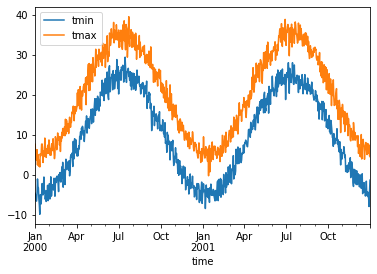

In [6]:
#visualize using dataframes
ds.mean(dim="location").to_dataframe().plot()

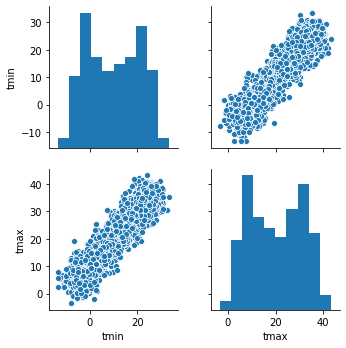

In [8]:
#visualize suing seaborn
sns.pairplot(df.reset_index(), vars=ds.data_vars)

In [9]:
#Probability of freeze by calendar month
freeze = (ds["tmin"] <= 0).groupby("time.month").mean("time")
freeze

<xarray.DataArray 'tmin' (month: 12, location: 3)>
array([[0.9516129 , 0.88709677, 0.93548387],
       [0.84210526, 0.71929825, 0.77192982],
       [0.24193548, 0.12903226, 0.16129032],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.01612903, 0.        ],
       [0.33333333, 0.35      , 0.23333333],
       [0.93548387, 0.85483871, 0.82258065]])
Coordinates:
  * location  (location) <U2 'IA' 'IN' 'IL'
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

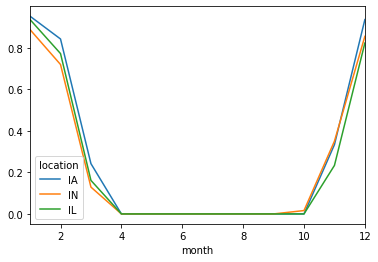

In [10]:
freeze.to_pandas().plot()

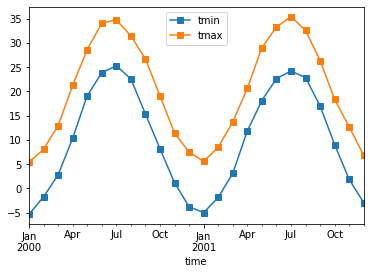

In [11]:
#Monthly averaging
monthly_avg = ds.resample(time="1MS").mean()
monthly_avg.sel(location="IA").to_dataframe().plot(style="s-")

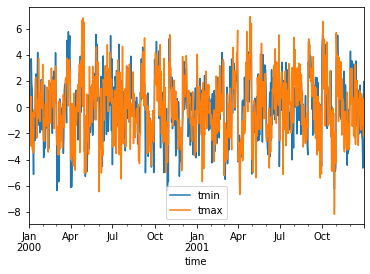

In [12]:
#Calculate monthly anomalies

climatology = ds.groupby("time.month").mean("time")
anomalies = ds.groupby("time.month") - climatology
anomalies.mean("location").to_dataframe()[["tmin", "tmax"]].plot()

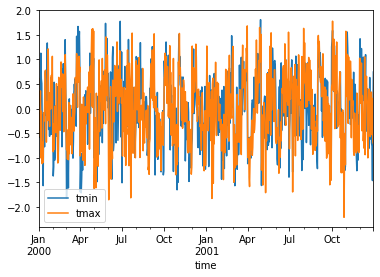

In [13]:
#Calculate standardized monthly anomalies

climatology_mean = ds.groupby("time.month").mean("time")
climatology_std = ds.groupby("time.month").std("time")
stand_anomalies = xr.apply_ufunc(
    lambda x, m, s: (x - m) / s,
    ds.groupby("time.month"),
    climatology_mean,
    climatology_std,
)

stand_anomalies.mean("location").to_dataframe()[["tmin", "tmax"]].plot()

In [14]:
#Fill missing values with climatology
# The fillna method on grouped objects lets you easily fill missing values by group:

# throw away the first half of every month
some_missing = ds.tmin.sel(time=ds["time.day"] > 15).reindex_like(ds)
filled = some_missing.groupby("time.month").fillna(climatology.tmin)
both = xr.Dataset({"some_missing": some_missing, "filled": filled})
both

<xarray.Dataset>
Dimensions:       (location: 3, time: 731)
Coordinates:
  * time          (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2001-12-31
  * location      (location) object 'IA' 'IN' 'IL'
    month         (time) int64 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12
Data variables:
    some_missing  (time, location) float64 nan nan nan ... 2.063 -1.346 -4.544
    filled        (time, location) float64 -5.163 -4.216 ... -1.346 -4.544

In [15]:
df = both.sel(time="2000").mean("location").reset_coords(drop=True).to_dataframe()
df.head()

,some_missing,filled
time,,
2000-01-01,NaN,-4.686763
2000-01-02,NaN,-4.686763
2000-01-03,NaN,-4.686763
2000-01-04,NaN,-4.686763
2000-01-05,NaN,-4.686763


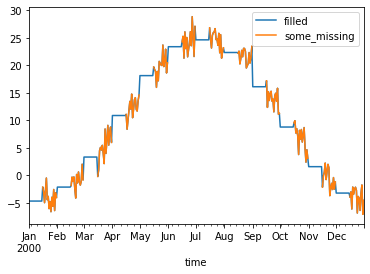

In [16]:
df[["filled", "some_missing"]].plot()